In [24]:
import requests
from bs4 import BeautifulSoup

# Prepare CSV file
topRatedCSV = "topRatedMovies.csv"
sep = ";"
CSV_headers = "tmdb_id"+sep+"title"+sep+"year"+sep+"runtime"+sep+"rating"+sep+"cast"+sep+"genres\n"
f = open(topRatedCSV, "w+")
f.write(CSV_headers)

# Get the top rated movies from the top rated list
def scrapeTopList(headers, url, n_pages):
    topMoviesList = []

    for page in range(1, n_pages+1):
        res_topRated = requests.get(url+'?page='+str(page), headers=headers)
        topRated_html = BeautifulSoup(res_topRated.content, "html.parser")

        print(url+'?page='+str(page), res_topRated.status_code)

        topListHTML = topRated_html.find("div", {"class": "media_items"}).find_all('a', {"class": "image"}) # type: ignore
        
        for title in topListHTML:
            movie_id = topListHTML[topListHTML.index(title)].get('href').split('/')[2]
            topMoviesList.append(movie_id)
    
    return topMoviesList

# Convert runtime to runtime in minutes
def runtime_convertion(movieRuntime):
    movieRuntime = movieRuntime.strip().lower()

    if "h" in movieRuntime and "m" in movieRuntime:
        hours, minutes = movieRuntime.split("h")
        minutes = minutes.split("m")[0]
        runtimeMinutes = int(hours) * 60 + int(minutes)

    elif "h" in movieRuntime:
        hours = movieRuntime.split("h")[0]
        runtimeMinutes = int(hours) * 60

    elif "m" in movieRuntime:
        minutes = movieRuntime.split("m")[0]
        runtimeMinutes = int(minutes)

    else:
        runtimeMinutes = int(movieRuntime)

    return runtimeMinutes

# Scrape movie details from movie page
def scrapeMovieDetails(headers, movie_id):
    url = 'https://www.themoviedb.org/movie/' + movie_id
    res_moviePage = requests.get(url, headers=headers)
    moviePage_html = BeautifulSoup(res_moviePage.content, "html.parser")

    print(url, res_moviePage.status_code)

    movieName = moviePage_html.find('div', {"class": "title"}).find('a').get_text() # type: ignore
    movieYear = moviePage_html.select_one('span.release_date').get_text(strip=True)[-5:-1]
    movieRuntime = runtime_convertion(moviePage_html.find('span', {"class": "runtime"}).get_text().strip().replace('\n', '').replace(' ', ''))
    movieRating = moviePage_html.find('div', {"class": "user_score_chart"}).get('data-percent').split('.')[0]
    movieGenresTags = moviePage_html.find_all('span', {"class": "genres"})[0].find_all('a')
    movieGenresString = ''
    for genre in movieGenresTags:
        movieGenresString += genre.get_text().replace(' ', '_') + '|'
    movieGenresString = movieGenresString[:-1]
    movieCastTags = moviePage_html.find_all('img', {"class": "profile"})
    movieCastString = ''
    for castTag in movieCastTags:
        castName = castTag.get('alt')
        movieCastString += castName.replace(' ', '_').replace('-', '_') + '|'
    movieCastString = movieCastString[:-1]

    print(f'"{movie_id}";"{movieName}";{movieYear};{movieRuntime};{movieRating};{movieCastString};{movieGenresString}', sep=sep, file=f)

In [25]:
# Scrape top rated movies
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 13.3; rv:109.0) Gecko/20100101 Firefox/113.0'}
url = 'https://www.themoviedb.org/movie/top-rated'
n_pages = 25 # 1 page = 20 movies
topList = scrapeTopList(headers, url, n_pages)

https://www.themoviedb.org/movie/top-rated?page=1 200
https://www.themoviedb.org/movie/top-rated?page=2 200
https://www.themoviedb.org/movie/top-rated?page=3 200
https://www.themoviedb.org/movie/top-rated?page=4 200
https://www.themoviedb.org/movie/top-rated?page=5 200
https://www.themoviedb.org/movie/top-rated?page=6 200
https://www.themoviedb.org/movie/top-rated?page=7 200
https://www.themoviedb.org/movie/top-rated?page=8 200
https://www.themoviedb.org/movie/top-rated?page=9 200
https://www.themoviedb.org/movie/top-rated?page=10 200
https://www.themoviedb.org/movie/top-rated?page=11 200
https://www.themoviedb.org/movie/top-rated?page=12 200
https://www.themoviedb.org/movie/top-rated?page=13 200
https://www.themoviedb.org/movie/top-rated?page=14 200
https://www.themoviedb.org/movie/top-rated?page=15 200
https://www.themoviedb.org/movie/top-rated?page=16 200
https://www.themoviedb.org/movie/top-rated?page=17 200
https://www.themoviedb.org/movie/top-rated?page=18 200
https://www.themovi

In [26]:
# Scrape details from movie page and write to CSV file
for movie_id in topList:
    scrapeMovieDetails(headers, movie_id)

# Close CSV file
f.close()

https://www.themoviedb.org/movie/238 200
https://www.themoviedb.org/movie/278 200
https://www.themoviedb.org/movie/240 200
https://www.themoviedb.org/movie/19404 200
https://www.themoviedb.org/movie/424 200
https://www.themoviedb.org/movie/129 200
https://www.themoviedb.org/movie/389 200
https://www.themoviedb.org/movie/372058 200
https://www.themoviedb.org/movie/496243 200
https://www.themoviedb.org/movie/155 200
https://www.themoviedb.org/movie/497 200
https://www.themoviedb.org/movie/680 200
https://www.themoviedb.org/movie/429 200
https://www.themoviedb.org/movie/13 200
https://www.themoviedb.org/movie/372754 200
https://www.themoviedb.org/movie/122 200
https://www.themoviedb.org/movie/769 200
https://www.themoviedb.org/movie/346 200
https://www.themoviedb.org/movie/696374 200
https://www.themoviedb.org/movie/11216 200
https://www.themoviedb.org/movie/637 200
https://www.themoviedb.org/movie/995133 200
https://www.themoviedb.org/movie/12477 200
https://www.themoviedb.org/movie/311 

In [92]:
import pandas as pd

def convert_genres(genres_str):
    return genres_str.split('|')

def convert_cast(genres_str):
    return genres_str.split('|')

df = pd.read_csv('topRatedMovies.csv', sep=';', converters={'genres': convert_genres, 'cast': convert_cast})

df['genre'] = df['genres'].apply(lambda x: list(x))
df['casts'] = df['cast'].apply(lambda x: list(x))

df.drop('genres', axis=1, inplace=True)
df.drop('cast', axis=1, inplace=True)

df

,tmdb_id,title,year,runtime,rating,genre,casts
0,238,The Godfather,1972,175,87,"[Drama, Crime]","[Al_Pacino, Marlon_Brando, James_Caan, Richard..."
1,278,The Shawshank Redemption,1994,142,87,"[Drama, Crime]","[Tim_Robbins, Morgan_Freeman, Bob_Gunton, Will..."
2,240,The Godfather Part II,1974,202,86,"[Drama, Crime]","[Al_Pacino, Robert_Duvall, Diane_Keaton, Rober..."
3,19404,Dilwale Dulhania Le Jayenge,1995,190,86,"[Comedy, Drama, Romance]","[Shah_Rukh_Khan, Kajol, Amrish_Puri, Anupam_Kh..."
4,424,Schindler's List,1993,195,86,"[Drama, History, War]","[Liam_Neeson, Ben_Kingsley, Ralph_Fiennes, Car..."
...,...,...,...,...,...,...,...
495,266856,The Theory of Everything,2014,123,79,"[Drama, Romance]","[Eddie_Redmayne, Felicity_Jones, Charlie_Cox, ..."
496,56231,The Working Class Goes to Heaven,1971,113,79,[Drama],"[Gian_Maria_Volonté, Mariangela_Melato, Salvo_..."
497,549559,Apollo 11,2019,93,79,"[Documentary, History]","[Neil_Armstrong, Buzz_Aldrin, Michael_Collins,..."
498,152601,Her,2013,126,79,"[Romance, Science_Fiction, Drama]","[Joaquin_Phoenix, Scarlett_Johansson, Amy_Adam..."


In [93]:
# Lowercase function
def lowercase(tokens):
    return [word.lower() for word in tokens]

# Lowercase
df['genre'] = df['genre'].apply(lowercase)
df['casts'] = df['casts'].apply(lowercase)

df

,tmdb_id,title,year,runtime,rating,genre,casts
0,238,The Godfather,1972,175,87,"[drama, crime]","[al_pacino, marlon_brando, james_caan, richard..."
1,278,The Shawshank Redemption,1994,142,87,"[drama, crime]","[tim_robbins, morgan_freeman, bob_gunton, will..."
2,240,The Godfather Part II,1974,202,86,"[drama, crime]","[al_pacino, robert_duvall, diane_keaton, rober..."
3,19404,Dilwale Dulhania Le Jayenge,1995,190,86,"[comedy, drama, romance]","[shah_rukh_khan, kajol, amrish_puri, anupam_kh..."
4,424,Schindler's List,1993,195,86,"[drama, history, war]","[liam_neeson, ben_kingsley, ralph_fiennes, car..."
...,...,...,...,...,...,...,...
495,266856,The Theory of Everything,2014,123,79,"[drama, romance]","[eddie_redmayne, felicity_jones, charlie_cox, ..."
496,56231,The Working Class Goes to Heaven,1971,113,79,[drama],"[gian_maria_volonté, mariangela_melato, salvo_..."
497,549559,Apollo 11,2019,93,79,"[documentary, history]","[neil_armstrong, buzz_aldrin, michael_collins,..."
498,152601,Her,2013,126,79,"[romance, science_fiction, drama]","[joaquin_phoenix, scarlett_johansson, amy_adam..."


In [94]:
# Count number of rows with drama in genre
df['genre'].apply(lambda x: 'drama' in x).sum()

# Count number of unique genres in df['genre']
unique_genres = set()
for genres in df['genre']:
    unique_genres.update(genres)
len(unique_genres)


19

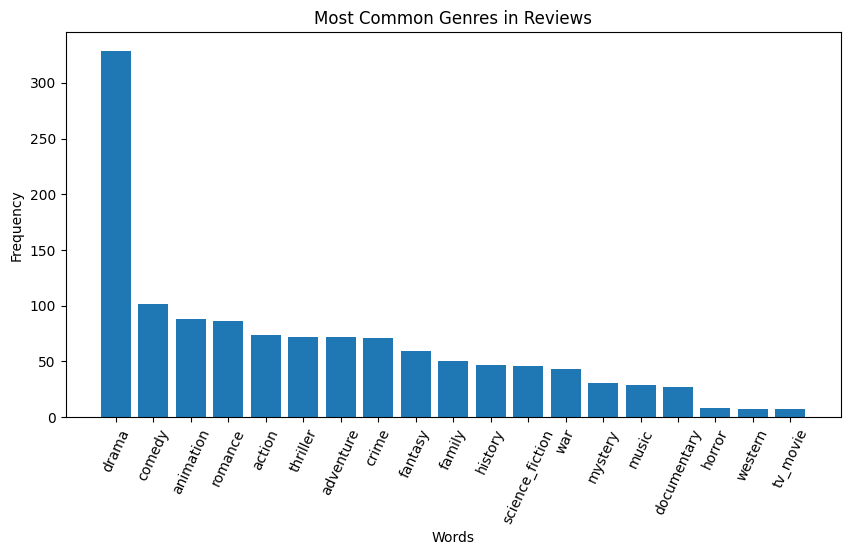

In [95]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

df['genre_str'] = df['genre'].apply(lambda tokens: ' '.join(tokens))
vectorizer = CountVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(df['genre_str'])

# Count the sum of each word
sum_words = X.sum(axis=0)

# Create a (word, frequency) list and sort it in descending order
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# Get the 10 most common words
common_words = words_freq[:32]

# Separate words and counts
words, counts = zip(*common_words)

# Plot word frequencies
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.title('Most Common Genres in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=65)
plt.show()

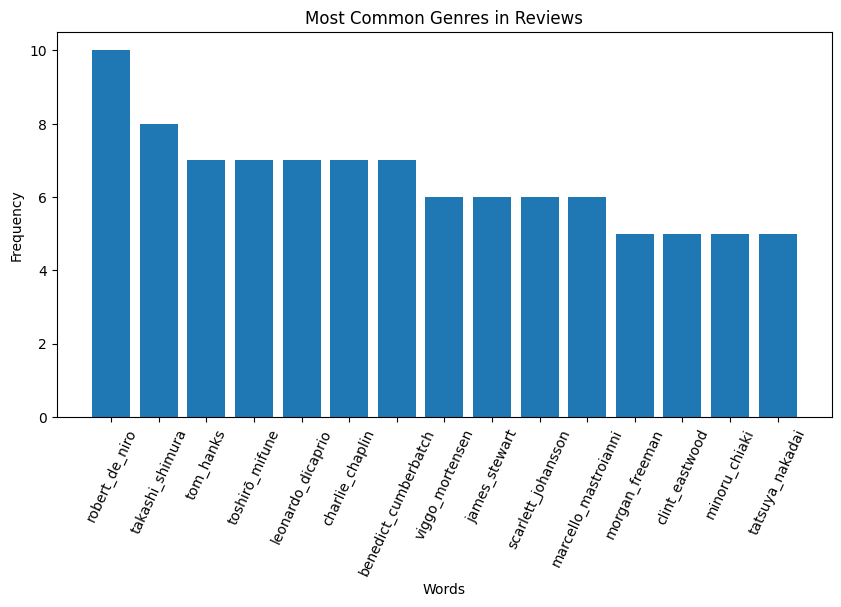

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

df['cast_str'] = df['casts'].apply(lambda tokens: ' '.join(tokens))
vectorizer = CountVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(df['cast_str'])

# Count the sum of each word
sum_words = X.sum(axis=0)

# Create a (word, frequency) list and sort it in descending order
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# Get the 10 most common words
common_words = words_freq[:15]

# Separate words and counts
words, counts = zip(*common_words)

# Plot word frequencies
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.title('Most Common Genres in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=65)
plt.show()

/tmp/ipykernel_25797/18020775.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['Cluster'] = kmeans.labels_


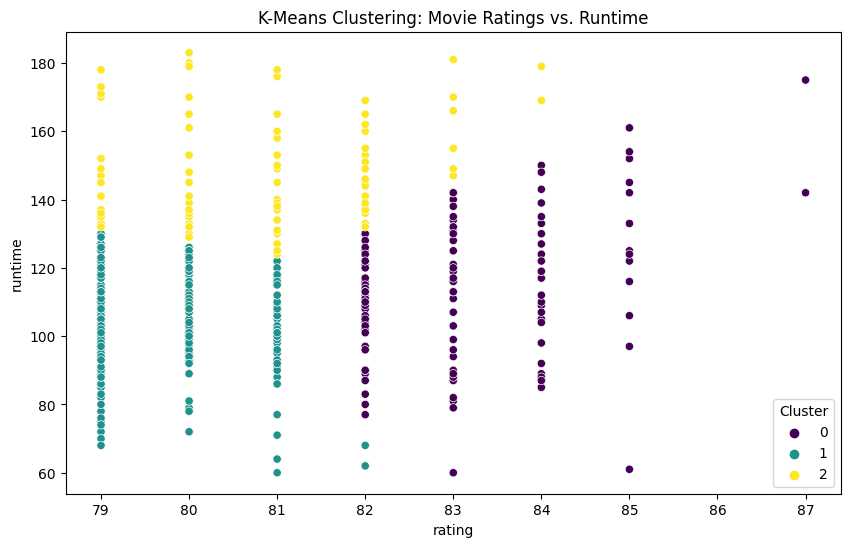

In [115]:
# Import required libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Let's say your DataFrame is named df and it's already loaded

# For this example, we're going to use only numerical columns.
# You can choose what suits best to your study
df_cluster = df[['rating', 'runtime']]

# Standardizing the features
scaler = StandardScaler()
df_std = scaler.fit_transform(df_cluster)

# Create a KMeans instance with 3 clusters: kmeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)

# Fit kmeans to the data
kmeans.fit(df_std)

# Create a new column with the labels from the KMeans clustering
df_cluster['Cluster'] = kmeans.labels_

# Visualizing the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_cluster, x='rating', y='runtime', hue='Cluster', palette='viridis')

plt.title('K-Means Clustering: Movie Ratings vs. Runtime')
plt.show()

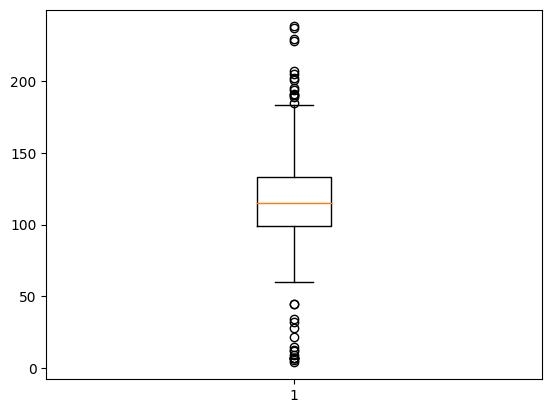

In [103]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
bp = ax.boxplot(df['runtime'], showfliers=True)

plt.show()

In [117]:
Q1 = df['runtime'].quantile(0.25)
Q3 = df['runtime'].quantile(0.75)
IQR = Q3 - Q1

# Define the acceptable range
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Identify the outliers
outliers = df[(df['runtime'] < lower_bound) | (df['runtime'] > upper_bound)]

# Print the outliers
print(outliers)

     tmdb_id              title  year  runtime  rating   
92    299534  Avengers: Endgame  2019      181      83  \
302    11778    The Deer Hunter  1978      183      80   

                                    genre   
92   [adventure, science_fiction, action]  \
302                          [drama, war]   

                                                 casts   
92   [robert_downey_jr., chris_evans, mark_ruffalo,...  \
302  [robert_de_niro, christopher_walken, john_caza...   

                            genre_str   
92   adventure science_fiction action  \
302                         drama war   

                                              cast_str  
92   robert_downey_jr. chris_evans mark_ruffalo chr...  
302  robert_de_niro christopher_walken john_cazale ...  


In [105]:
# Remove the outliers
df = df[(df['runtime'] > lower_bound) & (df['runtime'] < upper_bound)]

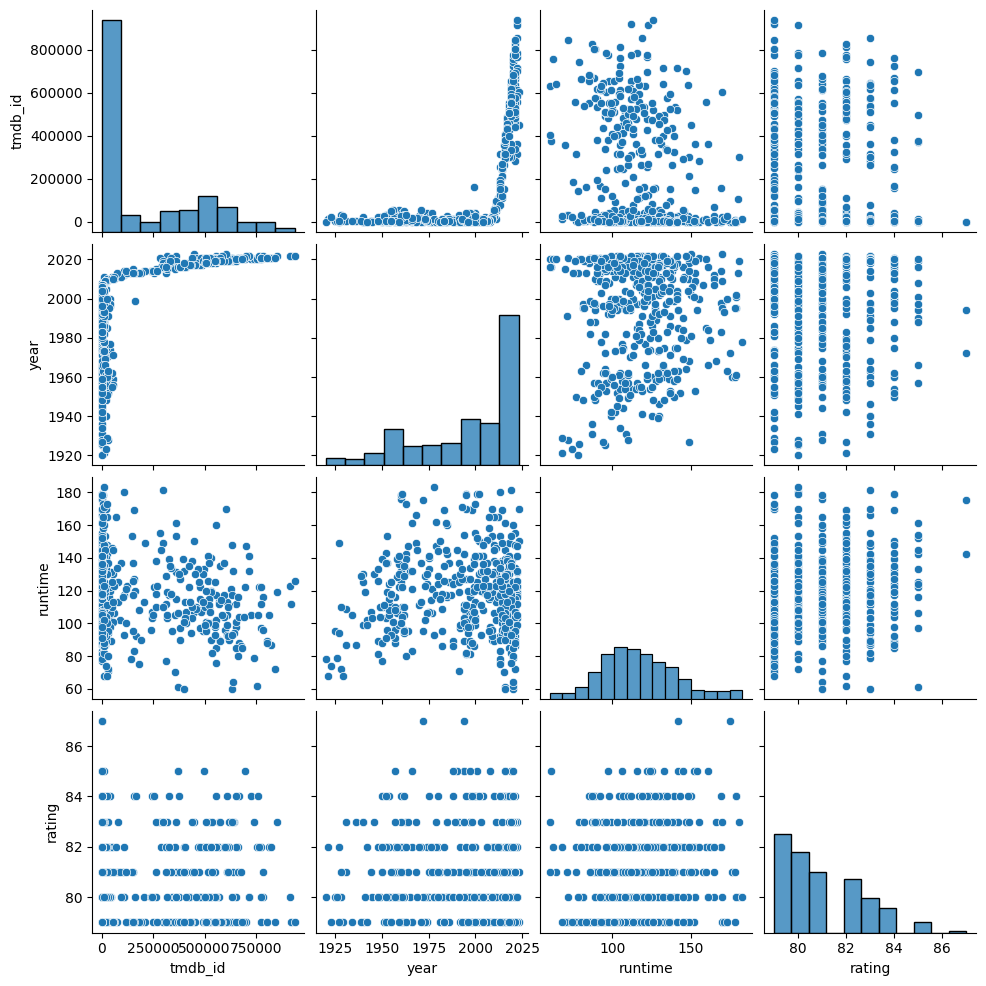

In [111]:
from matplotlib import pyplot

df_test = df[['rating', 'runtime']]

# Separate rating and runtime into individual arrays


sns.pairplot(df)
plt.show()


In [114]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")


ValueError: could not convert string to float: 'The Godfather'